# Preliminaries

This notebook lets you import a gym environment and set up an agent that acts within the environment. Your tasks is to then implement some of the classical RL algorithms: Value iteration and Policy iteration. Play attention to how you are going to evaluate your agents.

First, we make sure that all dependencies are met

In [1]:
!pip install gym > /dev/null 2>&1

# Testing the Gym environments

Our next step is to import the gym package, create an environment, and make sure that we can use it.

In [2]:
%matplotlib notebook
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

np.set_printoptions(precision=3, linewidth=200)

#create a cliff-walker
env = gym.make('CliffWalking-v0')

#set the start state
state = env.reset()
#and take some random actions
for i in range(4):
  #render the environment
  env.render()
  
  #select a random action
  action = env.action_space.sample()
  #take a step and record next state, reward and termination
  state, reward, done, _ = env.step(action)
  print("Acted: {}".format(action))
  print("State: {}".format(state))
  print("Reward: {}".format(reward))
  if done:
    #this environment only terminates once the goal is reached
    print("Done.")
    break

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Acted: 0
State: 24
Reward: -1
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Acted: 3
State: 24
Reward: -1
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Acted: 3
State: 24
Reward: -1
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Acted: 2
State: 36
Reward: -1


# Defining an agent

The next step is to define a class for our agents. We will derive from this class to later implement a Value Iteration, Policy Iteration and Monte Carlo control agent. The base class will only provide simple functionality.

In [3]:
class Agent :
  def __init__(self,env,discount_factor):
    self.env = env
    self.gamma = discount_factor
  
  def act(self, state):
    return self.env.action_space.sample() #returns a random action

  def evaluate(self):
    # now let's test our random action agent
    n_steps = 100 #number of steps per episode

    s = env.reset()
    episode_reward = 0
    
    for i in range(n_steps):
      s, r, d, _ = env.step(self.act(s))
      episode_reward += r
      if d:
        break
    return episode_reward

#test simple evaluation function
random_agent = Agent(env,0.99)
episode_reward=random_agent.evaluate()
print("Episode return {}".format(episode_reward))

Episode return -1585


# Non-determinsitic cliff walker

In [ ]:
from gym.envs.toy_text.cliffwalking import CliffWalkingEnv
import copy

class NonDCliffWalkingEnv(CliffWalkingEnv):
  def __init__(self):
    super(NonDCliffWalkingEnv, self).__init__()
  
  def _calculate_transition_prob(self, current, delta):
    """
    Determine the outcome for an action. Transition Prob is always 1.0.
    :param current: Current position on the grid as (row, col)
    :param delta: Change in position for transition
    :return: (1.0, new_state, reward, done)
    """
    transitions = []
    terminal_state = (self.shape[0] - 1, self.shape[1] - 1)
    deltas = [delta, [2*delta[0], 2*delta[1]]]
    zero_index = delta.index(0)
    delta_off = copy.copy(delta)
    delta_off[zero_index] = 1
    deltas.append(copy.copy(delta_off))
    delta_off[zero_index] = -1
    deltas.append(delta_off)
    probabilities = [0.85,0.05,0.05,0.05]

    
    for d,p in zip(deltas, probabilities):
      new_position = np.array(current) + np.array(d)
      new_position = self._limit_coordinates(new_position).astype(int)
      new_state = self.start_state_index if self._cliff[tuple(new_position)] else np.ravel_multi_index(tuple(new_position), self.shape)
      reward = -100 if self._cliff[tuple(new_position)] else -1
      is_done = tuple(new_position) == terminal_state
      #print(tuple(new_position), self._cliff[tuple(new_position)])
      transitions.append((p, new_state, reward, is_done))
    
    return transitions
  

# SARSA Agent



In [21]:
class SARSAAgent(Agent):
  def __init__(self,env,discount_factor,alpha,epsilon):
    super().__init__(env,discount_factor)
    #theta is an approximation error threshold
    self.alpha = alpha
    self.epsilon = epsilon
    self.Q = np.random.rand(self.env.shape[0], self.env.shape[1], self.env.nA)
    #set terminal state to 0
    self.Q[-1,-1,:] = 0

  def act(self, state): 
    #here choose action according to the epsilon-greedy policy
    position = np.unravel_index(state, self.env.shape)
    sample = np.random.rand()
    if sample > self.epsilon:
      action = np.argmax(self.Q[position[0], position[1],:].flatten())
    else:
      actions = list(range(self.env.nA))
      greedy_action = np.argmax(self.Q[position[0], position[1],:].flatten())
      actions.pop(actions.index(greedy_action))
      action = random.choice(actions)
    return action

   
  def run_one_episode(self):
    icliff = 0 
    episode = []
    done = False
    total_reward = 0
    self.env.reset()
   
    state = self.env.s
    action = self.act(state)
      
    istep = 0
    while (not done):
      new_state, reward, done, _ = self.env.step(action)      
      position = np.unravel_index(state, self.env.shape)
      # Select next action
      new_action = self.act(new_state)
      new_position = np.unravel_index(new_state, self.env.shape)
      # Update Q
      self.Q[position[0], position[1],action] = self.Q[position[0], position[1],action] + self.alpha * \
          (reward + self.gamma * self.Q[new_position[0], new_position[1],new_action] - self.Q[position[0], position[1],action]) 

      state = new_state
      action = new_action
      istep += 1
      total_reward += reward
      if reward == -100: #(self.env._cliff[tuple(new_position)]):
        icliff +=1 #print('Fell off the cliff')
        done = True
      
      
    #print('Took ' + str(istep) + ' steps. Fell off the cliff ' + str(icliff) + ' times')
    return total_reward
    
  def run_episodes(self, n, epsilon=None):
    rewards = []
    if epsilon is not None:
      self.epsilon = epsilon

    for i in range(n):
      rewards.append(self.run_one_episode())
      
      #print('Iteration ' + str(i) + ' done.')
    return(rewards)



In [67]:
gamma = 1.0
alpha = 0.9
epsilon = 0.2
SARSAagent = SARSAAgent(env,gamma,alpha,epsilon)
print(np.argmax(SARSAagent.Q, axis=2))

SARSArewards = []
for i in range(10):
  epsilon /= (i+1) 
  SARSArewards.extend(SARSAagent.run_episodes(50, epsilon))


[[3 0 1 2 0 3 0 1 3 0 1 3]
 [0 2 0 0 2 0 0 0 1 3 2 2]
 [3 0 2 1 3 0 2 2 2 1 3 3]
 [1 3 3 3 2 1 1 0 0 0 3 0]]


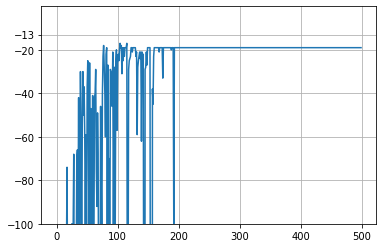

In [68]:
%matplotlib inline
fig,ax = plt.subplots(1)
ax.plot(SARSArewards)
ax.set_ylim(-100,0)
ax.grid()
ax.set_yticks(list(range(-100,0,20))+[-13])

# Q-learning Agent


In [45]:
class QLearningAgent(Agent):
  def __init__(self,env,discount_factor,alpha,epsilon):
    super().__init__(env,discount_factor)
    #theta is an approximation error threshold
    self.alpha = alpha
    self.epsilon = epsilon
    self.Q = np.random.rand(self.env.shape[0], self.env.shape[1], self.env.nA)
    #set terminal state to 0
    self.Q[-1,-1,:] = 0

  def act(self, state): 
    #here choose action according to the epsilon-greedy policy
    position = np.unravel_index(state, self.env.shape)
    sample = np.random.rand()
    if sample > self.epsilon:
      action = np.argmax(self.Q[position[0], position[1],:].flatten())
    else:
      actions = list(range(self.env.nA))
      greedy_action = np.argmax(self.Q[position[0], position[1],:].flatten())
      actions.pop(actions.index(greedy_action))
      action = random.choice(actions)
    return action

   
  def run_one_episode(self):
    icliff = 0 
    episode = []
    done = False
    total_reward = 0
    self.env.reset()
   
    state = self.env.s
    
      
    istep = 0
    while (not done):
      action = self.act(state)
      new_state, reward, done, _ = self.env.step(action)      
      position = np.unravel_index(state, self.env.shape)
      # Select greedy action
      new_position = np.unravel_index(new_state, self.env.shape)
      greedy_action = np.argmax(self.Q[new_position[0], new_position[1],:].flatten())
      # Update Q
      self.Q[position[0], position[1],action] = self.Q[position[0], position[1],action] + self.alpha * \
          (reward + self.gamma * self.Q[new_position[0], new_position[1],greedy_action] - self.Q[position[0], position[1],action]) 

      # Update state and choose next action
      state = new_state

      istep += 1
      total_reward += reward
      if reward == -100: #(self.env._cliff[tuple(new_position)]):
        icliff +=1 #print('Fell off the cliff')
        done = True
      
      
    #print('Took ' + str(istep) + ' steps. Fell off the cliff ' + str(icliff) + ' times')
    return total_reward
    
  def run_episodes(self, n, epsilon=None):
    rewards = []
    if epsilon is not None:
      self.epsilon = epsilon

    for i in range(n):
      rewards.append(self.run_one_episode())
      
      #print('Iteration ' + str(i) + ' done.')
    return(rewards)



In [81]:
gamma = 1.0
alpha = 0.9
epsilon = 0.1
Qagent = QLearningAgent(env,gamma,alpha,epsilon)
print(np.argmax(Qagent.Q, axis=2))

Qrewards = []
for i in range(10):
  epsilon /= (i+1) 
  Qrewards.extend(Qagent.run_episodes(50, epsilon))


[[1 0 2 0 0 2 1 2 1 2 3 3]
 [0 2 3 2 0 1 2 1 3 3 3 3]
 [1 0 1 1 0 3 1 0 2 1 0 2]
 [2 2 2 0 0 3 0 1 1 2 0 0]]


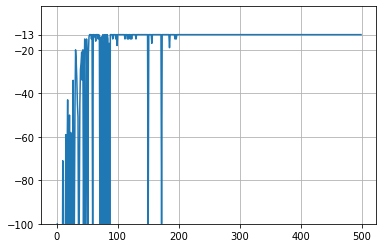

In [82]:
fig,ax = plt.subplots(1)
ax.plot(Qrewards)
ax.set_ylim(-100,0)
ax.grid()
ax.set_yticks(list(range(-100,0,20))+[-13])

# Expected SARSA agent

In [57]:
class ESARSAAgent(Agent):
  def __init__(self,env,discount_factor,alpha,epsilon):
    super().__init__(env,discount_factor)
    self.alpha = alpha
    self.epsilon = epsilon
    self.Q = np.random.rand(self.env.shape[0], self.env.shape[1], self.env.nA)
    #set terminal state to 0
    self.Q[-1,-1,:] = 0

  def act(self, state): 
    #here choose action according to the epsilon-greedy policy
    position = np.unravel_index(state, self.env.shape)
    sample = np.random.rand()
    if sample > self.epsilon:
      action = np.argmax(self.Q[position[0], position[1],:].flatten())
    else:
      actions = list(range(self.env.nA))
      greedy_action = np.argmax(self.Q[position[0], position[1],:].flatten())
      actions.pop(actions.index(greedy_action))
      action = random.choice(actions)
    return action

   
  def run_one_episode(self):
    icliff = 0 
    episode = []
    done = False
    total_reward = 0
    self.env.reset()
   
    state = self.env.s
    action = self.act(state)
      
    istep = 0
    while (not done):
      new_state, reward, done, _ = self.env.step(action)      
      position = np.unravel_index(state, self.env.shape)
      # Select next action
      new_action = self.act(new_state)
      new_position = np.unravel_index(new_state, self.env.shape)
      # Update Q
      probabilities = np.full(self.env.nA, self.epsilon/(self.env.nA - 1))
      greedy_action = np.argmax(self.Q[position[0], position[1],:].flatten())
      probabilities[greedy_action] = 1.-self.epsilon


      self.Q[position[0], position[1],action] = self.Q[position[0], position[1],action] + self.alpha * \
          (reward + self.gamma * np.sum(probabilities * self.Q[new_position[0], new_position[1],:]) - self.Q[position[0], position[1],action]) 

      state = new_state
      action = new_action
      istep += 1
      total_reward += reward
      if reward == -100: #(self.env._cliff[tuple(new_position)]):
        icliff +=1 #print('Fell off the cliff')
        done = True
      
      
    #print('Took ' + str(istep) + ' steps. Fell off the cliff ' + str(icliff) + ' times')
    return total_reward
    
  def run_episodes(self, n, epsilon=None):
    rewards = []
    if epsilon is not None:
      self.epsilon = epsilon

    for i in range(n):
      rewards.append(self.run_one_episode())
      
      #print('Iteration ' + str(i) + ' done.')
    return(rewards)

In [83]:
gamma = 1.0
alpha = 1.0
epsilon = 0.2
ESARSAagent = ESARSAAgent(env,gamma,alpha,epsilon)
print(np.argmax(ESARSAagent.Q, axis=2))

ESARSArewards = []
for i in range(10):
  epsilon /= (i+1) 
  ESARSArewards.extend(ESARSAagent.run_episodes(50, epsilon))


[[1 1 3 2 1 2 0 3 3 1 1 0]
 [2 1 1 0 1 0 3 0 2 0 2 2]
 [1 0 0 1 0 1 3 3 2 3 0 1]
 [1 2 3 3 1 3 2 2 0 2 1 0]]


Text(0, 0.5, 'Total reward per episode')

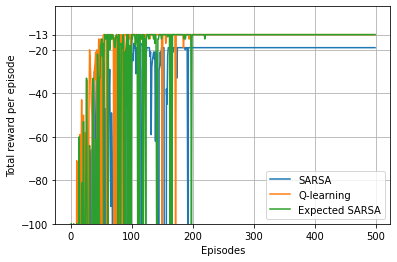

In [87]:
fig,ax = plt.subplots(1)
ax.plot(SARSArewards)
ax.plot(Qrewards)
ax.plot(ESARSArewards)
ax.set_ylim(-100,0)
ax.grid()
ax.set_yticks(list(range(-100,0,20))+[-13])
ax.legend(['SARSA','Q-learning','Expected SARSA'])
ax.set_xlabel('Episodes')
ax.set_ylabel('Total reward per episode')

In [62]:
episode_reward=agent.evaluate()
print("Episode return {}".format(episode_reward))

print(np.argmax(agent.Q, axis=2))

Episode return -13
[[1 1 0 1 1 1 1 1 1 1 1 2]
 [3 1 0 1 1 1 1 1 1 1 1 2]
 [1 1 1 1 1 1 1 1 1 1 1 2]
 [0 1 2 0 0 0 3 3 0 1 3 0]]


In [ ]:
#evaluate agent and plot relevant qualities
episode_reward=pagent.evaluate()
print("Episode return {}".format(episode_reward))

print(pagent.Q[1,0])
print(np.argmax(pagent.policy, axis=2))

Episode return -100
[ -96.611 -141.383 -152.218 -155.649]
[[1 1 3 1 1 1 1 1 1 1 1 2]
 [0 0 0 3 1 0 3 3 0 0 0 2]
 [1 0 0 0 1 0 0 3 3 3 0 2]
 [0 2 1 3 1 3 1 1 3 0 3 0]]
